# 1. Download e tratamento do DataSet

## 1.1. Download dos dados

In [11]:
import os
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Dropout, Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# 2. Carregamento do dataset

In [2]:
# Caminhos dos diretórios
train_watermarked_path = 'CLWD/train/Watermarked_image'
train_non_watermarked_path = 'CLWD/train/Watermark_free_image'
test_watermarked_path = 'CLWD/test/Watermarked_image'
test_non_watermarked_path = 'CLWD/test/Watermark_free_image'
results_filename = 'vgg16_unet'

# Parâmetros
batch_size = 32
validation_split = 0.2
img_dim = 64
img_size = (img_dim, img_dim)
steps_per_epoch = (1 - validation_split) * len(os.listdir(train_watermarked_path)) // batch_size
validation_steps = validation_split * len(os.listdir(train_watermarked_path)) // batch_size

In [3]:
def create_dataset(watermarked_path, non_watermarked_path, img_size, batch_size, validation_split=0.2, subset=None, shuffle=True):
    # Lista de arquivos
    watermarked_files = sorted([os.path.join(watermarked_path, f) for f in os.listdir(watermarked_path)])
    non_watermarked_files = sorted([os.path.join(non_watermarked_path, f) for f in os.listdir(non_watermarked_path)])

    # Certifique-se de que os arquivos correspondem em ordem
    assert len(watermarked_files) == len(non_watermarked_files), "Os conjuntos de dados devem ter o mesmo tamanho."
    
    # Determinar índice de divisão
    split_index = int(len(watermarked_files) * (1 - validation_split))

    if subset == "training":
        watermarked_files = watermarked_files[:split_index]
        non_watermarked_files = non_watermarked_files[:split_index]
    elif subset == "validation":
        watermarked_files = watermarked_files[split_index:]
        non_watermarked_files = non_watermarked_files[split_index:]

    # Criar dataset com pares de caminhos
    dataset = tf.data.Dataset.from_tensor_slices((watermarked_files, non_watermarked_files))

    # Função para carregar e pré-processar as imagens
    def preprocess(w_file, nw_file):
        w_img = tf.io.read_file(w_file)
        w_img = tf.image.decode_jpeg(w_img, channels=3)
        w_img = tf.image.resize(w_img, img_size) / 255.0

        nw_img = tf.io.read_file(nw_file)
        nw_img = tf.image.decode_jpeg(nw_img, channels=3)
        nw_img = tf.image.resize(nw_img, img_size) / 255.0

        return w_img, nw_img

    # Aplicar pré-processamento
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Embaralhar se necessário
    if shuffle and subset == "training":
        dataset = dataset.shuffle(buffer_size=1000)

    # Dividir em lotes e aplicar prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# 3. Construção da UNet


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gc

def build_unet_with_vgg16(input_shape=(64, 64, 3)):
    # Carregar a VGG16 pré-treinada como backbone
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg16.trainable = False  # Congelar pesos da VGG16

    # Encoder usando os blocos da VGG16
    input_img = vgg16.input
    skip1 = vgg16.get_layer("block1_conv2").output  # Primeira skip connection
    skip2 = vgg16.get_layer("block2_conv2").output  # Segunda skip connection
    skip3 = vgg16.get_layer("block3_conv3").output  # Terceira skip connection
    bottleneck = vgg16.get_layer("block4_conv3").output  # Quarta skip connection
    
    # Decoder: Up-sampling e skip connections
    u7 = UpSampling2D((2, 2))(bottleneck)
    u7 = Conv2D(256, (2, 2), activation='relu', padding='same')(u7)
    u7 = Concatenate()([u7, skip3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Conv2D(128, (2, 2), activation='relu', padding='same')(u8)
    u8 = Concatenate()([u8, skip2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Conv2D(64, (2, 2), activation='relu', padding='same')(u9)
    u9 = Concatenate()([u9, skip1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output layer
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    # Define the model
    unet_model = Model(input_img, outputs)
    return unet_model

# Instanciar o modelo
unet_vgg16 = build_unet_with_vgg16()
unet_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Adicionar callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_vgg16_model.h5',  # Salva o melhor modelo
        monitor='val_loss',  # Monitora a perda de validação
        save_best_only=True, # Salva apenas se for o melhor modelo
        verbose=1
    )
]

unet_vgg16.summary()

# Liberação de memória
gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

452

# 4. Treinamento do modelo

In [5]:
train_dataset = create_dataset(
    train_watermarked_path, train_non_watermarked_path, 
    img_size, batch_size, validation_split=validation_split, subset="training"
)

val_dataset = create_dataset(
    train_watermarked_path, train_non_watermarked_path, 
    img_size, batch_size, validation_split=validation_split, subset="validation"
)

with tf.device("/device:GPU:0"):
    # Treinamento
    history = unet_vgg16.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=callbacks,
        epochs=50
    )

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00425, saving model to best_vgg16_model.h5
1500/1500 [==============================] - 108s 68ms/step - loss: 0.0044 - val_loss: 0.0042 - lr: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00425 to 0.00372, saving model to best_vgg16_model.h5
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0032 - val_loss: 0.0037 - lr: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 0.00372 to 0.00305, saving model to best_vgg16_model.h5
1500/1500 [==============================] - 105s 70ms/step - loss: 0.0029 - val_loss: 0.0031 - lr: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 0.00305 to 0.00248, saving model to best_vgg16_model.h5
1500/1500 [==============================] - 112s 74ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 0.00248 to 0.00247, saving model to best_vgg16_model.h5
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0023 -

# 5. Avaliação e visualização dos resultados

Imagens salvas em: results\vgg16_unet_training.png


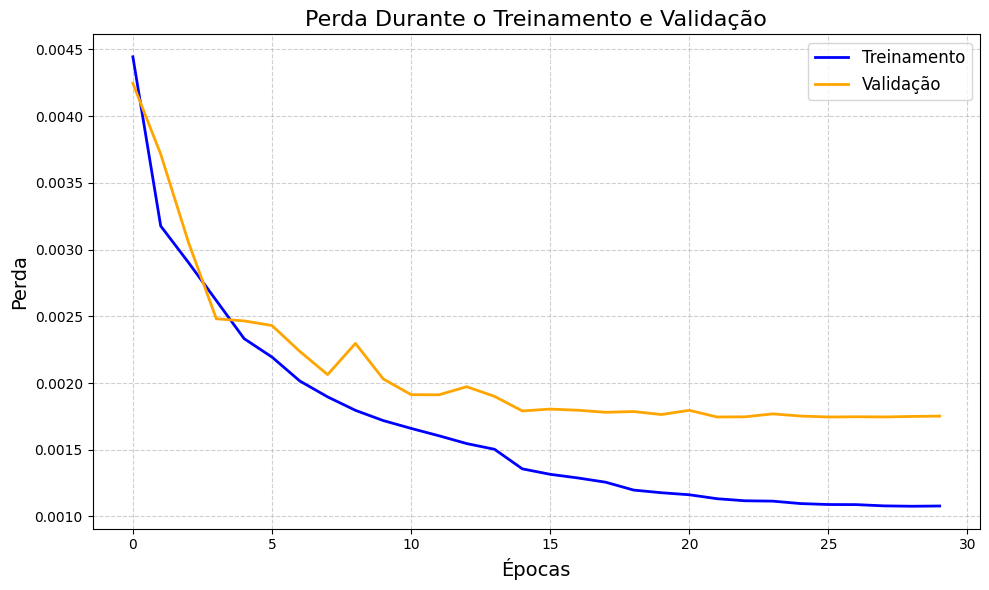

In [6]:
def plot_training_history(history, output_dir="output", file_name="train_history.png"):

    # Cria o diretório de saída, se necessário
    os.makedirs(output_dir, exist_ok=True)
    
    # Caminho completo para salvar o arquivo
    output_path = os.path.join(output_dir, file_name)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Treinamento', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validação', color='orange', linewidth=2)
    plt.title('Perda Durante o Treinamento e Validação', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Perda', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_path)  # Salva o plot no arquivo
    print(f"Imagens salvas em: {output_path}")
    plt.show()
    plt.close()

# Chamando a função após o treinamento
plot_training_history(history, output_dir="results", file_name=results_filename+'_training.png')

In [7]:
def load_image(file_path, img_size):
    """
    Carrega uma imagem a partir do caminho e redimensiona.
    """
    image = tf.keras.utils.load_img(file_path, target_size=img_size)
    image = tf.keras.utils.img_to_array(image) / 255.0  # Normaliza para [0, 1]
    return image


def create_test_dataset(watermarked_path, non_watermarked_path, img_size, batch_size):
    """
    Cria o dataset de teste com pares de imagens (com e sem marca d'água).
    """
    # Lista arquivos nos diretórios
    watermarked_files = sorted(os.listdir(watermarked_path), key=lambda x: int(x.split('.')[0]))
    non_watermarked_files = sorted(os.listdir(non_watermarked_path), key=lambda x: int(x.split('.')[0]))
    
    # Verifica se os dois conjuntos possuem o mesmo número de arquivos
    assert len(watermarked_files) == len(non_watermarked_files), \
        "O número de arquivos nos dois diretórios deve ser o mesmo."

    # Carrega as imagens
    watermarked_images = [
        load_image(os.path.join(watermarked_path, file), img_size) for file in watermarked_files
    ]
    non_watermarked_images = [
        load_image(os.path.join(non_watermarked_path, file), img_size) for file in non_watermarked_files
    ]

    # Combina em pares
    dataset = tf.data.Dataset.from_tensor_slices((watermarked_images, non_watermarked_images))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

test_dataset = create_test_dataset(
    test_watermarked_path, test_non_watermarked_path, img_size, batch_size
)

In [12]:
def evaluate_model_metrics(model, dataset, max_pixel_value=1.0):

    rmse_values = []
    psnr_values = []
    ssim_values = []

    with tf.device("/device:GPU:0"):

        for watermarked, non_watermarked in dataset:
            # Previsão pelo modelo
            reconstructed = model.predict(watermarked, verbose=0)
    
            # Converte para arrays NumPy, se necessário
            y_true = non_watermarked.numpy() if hasattr(non_watermarked, 'numpy') else np.array(non_watermarked)
            y_pred = reconstructed
    
            # Normaliza as imagens, se necessário
            y_true = np.clip(y_true, 0, max_pixel_value)
            y_pred = np.clip(y_pred, 0, max_pixel_value)
    
            # Calcula RMSE
            mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
    
            # Calcula PSNR
            psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse)) if mse > 0 else float('inf')
            psnr_values.append(psnr)
    
            # Calcula SSIM
            ssim_value = ssim(y_true, y_pred, data_range=max_pixel_value, multichannel=True, channel_axis=-1)
            ssim_values.append(ssim_value)

    # Calcula as médias de cada métrica
    metrics = {
        "RMSE": np.mean(rmse_values),
        "PSNR": np.mean(psnr_values),
        "SSIM": np.mean(ssim_values)
    }
    return metrics

# Calcula RMSE no conjunto de treinamento
train_metrics = evaluate_model_metrics(unet_vgg16, train_dataset)
print("Métricas médias do treinamento:")
print(f"RMSE: {train_metrics['RMSE']:.4f}")
print(f"PSNR: {train_metrics['PSNR']:.2f} dB")
print(f"SSIM: {train_metrics['SSIM']:.4f}")

# Calcula RMSE no conjunto de validacao
val_metrics = evaluate_model_metrics(unet_vgg16, val_dataset)
print("Métricas médias da validacao:")
print(f"RMSE: {val_metrics['RMSE']:.4f}")
print(f"PSNR: {val_metrics['PSNR']:.2f} dB")
print(f"SSIM: {val_metrics['SSIM']:.4f}")

# Calcula o RMSE no conjunto de teste
test_metrics = evaluate_model_metrics(unet_vgg16, test_dataset)
print("Métricas médias do teste:")
print(f"RMSE: {test_metrics['RMSE']:.4f}")
print(f"PSNR: {test_metrics['PSNR']:.2f} dB")
print(f"SSIM: {test_metrics['SSIM']:.4f}")

Métricas médias do treinamento:
RMSE: 0.0328
PSNR: 29.75 dB
SSIM: 0.9887
Métricas médias da validacao:
RMSE: 0.0415
PSNR: 27.71 dB
SSIM: 0.9817
Métricas médias do teste:
RMSE: 0.0511
PSNR: 25.89 dB
SSIM: 0.9739


Imagens salvas em: results\vgg16_unet_images.png


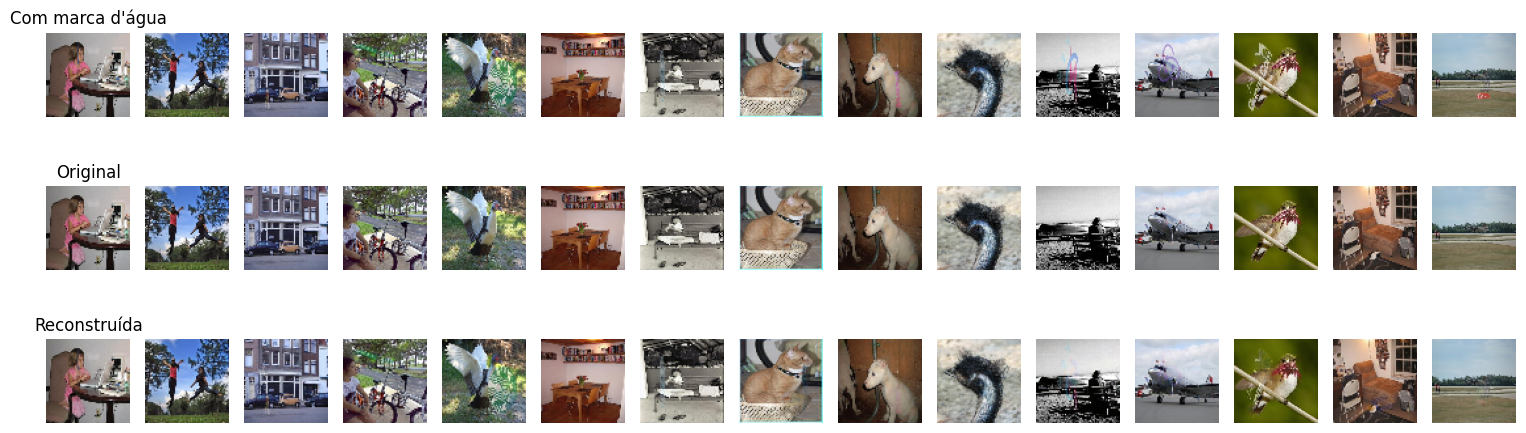

In [13]:
def save_and_show_reconstructed_images(model, test_dataset, num_images=15, output_dir="output", file_name="reconstructed_images.png"):

    # Cria o diretório de saída, se necessário
    os.makedirs(output_dir, exist_ok=True)
    
    # Caminho completo para salvar o arquivo
    output_path = os.path.join(output_dir, file_name)
    
    # Obtém um lote de imagens do dataset de teste
    for watermarked, non_watermarked in test_dataset.take(1):
        # Previsão do modelo
        reconstructed = model.predict(watermarked, verbose=0)

        # Número de imagens a serem plotadas
        num_images = min(num_images, watermarked.shape[0])

        plt.figure(figsize=(15, 5))

        for i in range(num_images):
            # Imagem com marca d'água
            ax = plt.subplot(3, num_images, i + 1)
            plt.imshow(watermarked[i])
            if i == 0:
                plt.title("Com marca d'água")
            plt.axis("off")

            # Imagem original
            ax = plt.subplot(3, num_images, i + 1 + num_images)
            plt.imshow(non_watermarked[i])
            if i == 0:
                plt.title("Original")
            plt.axis("off")

            # Imagem reconstruída
            ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(reconstructed[i])
            if i == 0:
                plt.title("Reconstruída")
            plt.axis("off")

        plt.tight_layout()
        plt.savefig(output_path)  # Salva o plot no arquivo
        print(f"Imagens salvas em: {output_path}")
        plt.show()  # Exibe a figura na tela
        plt.close()  # Fecha a figura para liberar memória
        break  # Apenas um lote é necessário

# Plota 15 imagens do conjunto de teste
save_and_show_reconstructed_images(unet_vgg16, test_dataset, num_images=15, output_dir="results", file_name=results_filename+'_images.png')

# 6. Salvar o modelo treinado

In [14]:
# Salvar o modelo treinado
unet_vgg16.save('models/'+results_filename+'.h5')